In [1]:
!pip install torch torchvision matplotlib

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [2]:
data_root = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset'


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Correct root
data_root = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset'

# Load datasets
train_data = datasets.ImageFolder(os.path.join(data_root, 'Train'), transform=transform)
val_data = datasets.ImageFolder(os.path.join(data_root, 'Validation'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_root, 'Test'), transform=transform)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Check class names
print("Classes:", train_data.classes)




Classes: ['WithMask', 'WithoutMask']


In [7]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Then move the model
model = model.to(device)
# Use the updated weights parameter
weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)

# Freeze features
for param in model.features.parameters():
    param.requires_grad = False

# Update the classifier
model.classifier[1] = nn.Linear(model.last_channel, 2)
model = model.to(device)


In [8]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer (only train classifier layer)
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)


In [9]:
num_epochs = 5  

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch [1/5], Loss: 0.1374, Accuracy: 95.41%
Epoch [2/5], Loss: 0.0633, Accuracy: 98.00%
Epoch [3/5], Loss: 0.0496, Accuracy: 98.43%
Epoch [4/5], Loss: 0.0419, Accuracy: 98.66%
Epoch [5/5], Loss: 0.0474, Accuracy: 98.40%


In [10]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 99.70%


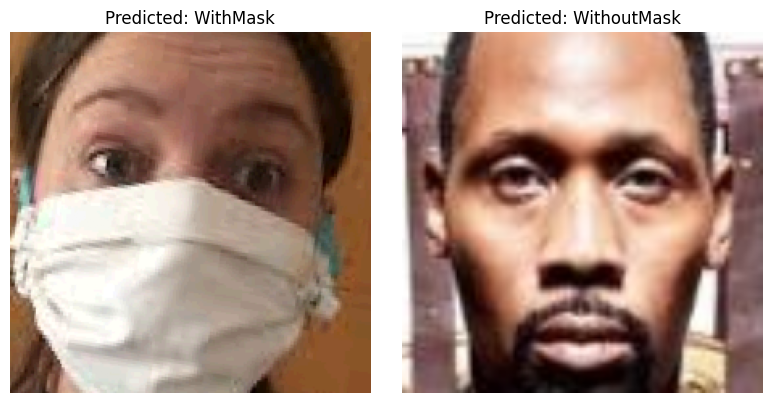

In [12]:
import matplotlib.pyplot as plt

# Get class names
classes = train_data.classes

# Function to plot side-by-side predictions
def plot_predictions_side_by_side():
    dataiter = iter(test_loader)
    
    for _ in range(len(test_loader)):  # Try each batch until found
        images, labels = next(dataiter)
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Find indices for WithMask and WithoutMask
        try:
            with_mask_idx = (preds == classes.index('WithMask')).nonzero(as_tuple=True)[0][0].item()
            without_mask_idx = (preds == classes.index('WithoutMask')).nonzero(as_tuple=True)[0][0].item()

            # Plot if both found
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            axes[0].imshow(images[with_mask_idx].permute(1, 2, 0).cpu())
            axes[0].set_title(f"Predicted: {classes[preds[with_mask_idx]]}")
            axes[0].axis('off')

            axes[1].imshow(images[without_mask_idx].permute(1, 2, 0).cpu())
            axes[1].set_title(f"Predicted: {classes[preds[without_mask_idx]]}")
            axes[1].axis('off')

            plt.tight_layout()
            plt.show()
            return  # Exit after successful plot

        except IndexError:
            continue  # If not found in this batch, try the next one

    print("Couldn't find both classes in any batch. Try increasing batch size or checking class labels.")

# Call the function
plot_predictions_side_by_side()


In [ ]:
plt.savefig("output.png")